<a href="https://colab.research.google.com/github/danpamplona/TareasMineria/blob/main/Ejemplo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Daniel E.  Quintero Pamplona
# Ejemplo completo para un problema de regresión usando sci-kitlearn

El siguiente ejemplo presenta las etapas básicas de un proyecto de analítica de datos en una tarea de regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [FIFA 2019 - Kaggle](https://www.kaggle.com/karangadiya/fifa19).

In [ ]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2021-11-26 19:50:25--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-5s-docs.googleusercontent.com/docs/securesc/d3j9aegmo3rno6jehj7au6tgtb7jmi7i/894au4742egoub1k9k55hvh6u8qai6je/1637956200000/09173029842254050324/14887018803820884505Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download [following]
--2021-11-26 19:50:31--  https://doc-08-5s-docs.googleusercontent.com/docs/securesc/d3j9aegmo3rno6jehj7au6tgtb7jmi7i/894au4742egoub1k9k55hvh6u8qai6je/1637956200000/09173029842254050324/14887018803820884505Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download
Resolving doc-08-5s-docs.googleusercontent.com (doc-08-5s-docs.googleusercontent.com)... 74.125.135.132, 2607:f8b0:400e:c01::84
Connecting to 

# Lectura de la base de datos con Pandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#librerias para proceso
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From'] #variables a descartar - no contienen información relevante
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,7/1/2004,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,7/10/2018,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,8/3/2017,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,7/1/2011,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,8/30/2015,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [ ]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

# Partición en conjunto de training y testing.

## Tips básicos para escoger la estrategia de validación:

- Para $N\geq 5000$ se sugiere realizar entrenamiento hold-out, generando grupos de entrenamiento, validación y evaluación. Los conjuntos de entrenamiento y validación se pueden utilizar para realizar validación cruzada de 10 o 5 folds para determinar el mejor modelo y sus hiperparámetros. No obstante, si la cantidad de datos es muy grande, generalmente se utiliza un único conjunto de entrenamiento y un único conjunto de validación, e.g., modelos de deep learning generalmente utilizan esta estrategia por la gran cantidad de datos disponible.

**HoldOut con única partición de entrenamiento, validación y evaluación (training, validation, testing)**

![HoldOut](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/HoldOut.png?raw=1)


**HoldOut utilizando validación cruzada para definir varios conjuntos de entrenamiento y validación en la búsqueda del mejor modelo con evaluación final en un único conjunto de testing**

![grid_search_cross_validation](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/grid_search_cross_validation.png?raw=1)

- Se sugiere para $ 30 <N <5000$ realizar validación cruzada o validación cruzada anidad k folds (generalmente se trabaja con k=10 o k = 5), y reportar el desempeño promedio en el conjunto de test a lo largo de las rotaciones. En algunos textos, dado que se los datos se rotan y aparecen al menos una vez en el conjunto de training y una vez en el de testing, se habla solamente de conjuntos de entrenamiento y validación, porque el concepto de datos afuera (testing) se pierde.

![kfolds](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/kfolds.png?raw=1)

- La validación cruzada anidad es mucho más estricta a la hora de dejar un conjunto de test que no se utiliza para sintonizar los hiperparámetros (a diferencia del kfolds convencional que determina los mejores valores de hiperparametros respecto al conjunto de validación=evaluación). Sin embargo, la extensión anidad es más costosa computacionalmente.


![nestedcv](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/nestedcv.png?raw=1)

- Para $N \leq 30$ se sugiere trabajar con validación cruzada fijando el número de particiones igual al número de datos ($k=N$). En este caso, se tiene un conjunto de entrenamiento de $N-1$ y una única muestra de test que se rota $N$ veces (leave-one-out).



**Nota**: En este caso se cuenta con una buena cantidad de datos 18.000 aprox., por lo que se realizará una validación hold-out, con 70% de datos para entrenamiento y 30% para evaluación. Sobre el conjunto de entrenamiento se realizará una validación cruzada de 5 folds (k=5) para determinar el mejor modelo e hiperparámetros. 

Se define el atributo Release Clause como salida.

In [ ]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


**Nota**: Recuerde que puede usar la partición estratificada para preservar la distribución de la salida de interés en los folds

# Preproceso: completar datos y codificar datos tipo texto


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


**Nota**: Dado que la variable de salida esta en formato moneda se debe codificar meidante función particular (custom). También, se creará una función para codificar las variables tipo evolución características del jugador.

---



In [ ]:
print(ytrain[0],Xtrain.loc[0,"LS"])

KeyError: ignored

In [ ]:
 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc 

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc   

In [ ]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [ ]:
ytrain_num[:5]

array([ 709000., 2600000., 1600000.,  155000., 5200000.])

## Se definen las variables para codificar utilizando las funciones establecidas de moneda, estadísticas y las tipo texto con OrdinalEncoder y OneHotEncoder.

In [ ]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']#variables a codificar OrdinalEncoder y OneHotEncoder
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))#se crean diccionarios con las variables y sus posibles valores

In [ ]:
Xdata['Nationality'].value_counts().index

Index(['England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy',
       'Colombia', 'Japan', 'Netherlands',
       ...
       'Mauritius', 'Indonesia', 'Botswana', 'Grenada', 'Puerto Rico',
       'Rwanda', 'Ethiopia', 'Liberia', 'South Sudan', 'Qatar'],
      dtype='object', length=164)

In [ ]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

# Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [ ]:
#%% transformer custom
from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador
        
        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))
        
        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .       
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades 
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante
        
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")#codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        #si utilizar OneHotEncoder debe concatenar las columnas resultantes -> ver cuaderno guia lado a lado
        
        return self    

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])
        
        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])
        
                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')
            
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi
    
    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

In [ ]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

**Nota**: Recuerde que ninguna etapa del proceso puede utilizar los datos de test para sintonizar parámetros.

In [ ]:
Xtest_pre = mypre.transform(Xtest) #no se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [ ]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12744 entries, 10308 to 12874
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  float64
 10  Weak Foot                 12744 non-null  float64
 11  Skill Moves               12744 non-null  float64
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Re

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Se realiza análisis exploratorio básico

In [ ]:
corr_matrix = Xtrain_pre.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

# Ejercicio 1:

1. Qué puede discutir sobre las correlaciones cálculadas?

##Solución 
En general se aprecia que algunos atributos presentan correlaciones altas o bajas, pero en su mayoría no hay correlaciones muy fuertes. 
Dentro de la matriz se aprecia que en el centro se tiene un bloque rojo, en el cual se puede apreciar que están aportando información similar.
Además se tiene otro bloque en la parte inferior derecha que también tiene correlaciones muy altas. Pero en general se puede observar que:
- El atributo  Overall tiene una relación positiva considerablemente alta con las variables Potential y Value.
- El atributo Value stiene una correlación positiva con las variables Wage, Potential y International Reputation.
- Los atrubutos LS - ST - RS tienen una correlación igual a uno, por lo que se puede reducir a una sola variable pues estan explicando lo mismo (lo comentado en el encabezado). Además, sucede lo mismo con LCM - CM - RCM, que poseen correlaciones igual a uno.
-Los atributos GKDiving GKHandling GKKicking GKPositioning y GKReflexes, se encuentran altamente correlacionadas.

2. Cuáles son los atributos que presentan una relación lineal más fuerte con la variable de salida?

##Solución 

Para indicar las correlaciones más altas con la variable respuesta, vamos a unir la variable Release Clause convirtiéndola en un objeto panda. 

In [ ]:
y_num = pd.DataFrame(ytrain_num, columns = ['Release clause'])
y_num.head()

,Release clause
0,1000000.0
1,667000.0
2,108000.0
3,609000.0
4,1100000.0


Ahora, se usará la función copncatenar para que la matriz de correlación tenga en cuenta esta variable. 

In [ ]:
completa_train=pd.concat([Xtrain_pre.reset_index(drop=True), y_num],axis=1)
completa_train.head(5)

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release clause
0,29,30.0,67,67,275.0,575000.0,7000.0,1792,0.0,1.0,3.0,2.0,1.0,0.0,0.0,5.0,23.0,832017.0,2.0,5.11,163.0,58.0,58.0,58.0,60.0,58.0,58.0,58.0,60.0,60.0,60.0,60.0,62.0,63.0,63.0,63.0,62.0,68.0,66.0,66.0,...,68.0,66.0,66.0,66.0,68.0,70.0,43.0,59.0,64.0,49.0,57.0,67.0,59.0,64.0,63.0,61.0,67.0,74.0,63.0,75.0,59.0,74.0,78.0,63.0,56.0,59.0,66.0,49.0,52.0,61.0,64.0,70.0,66.0,64.0,6.0,9.0,8.0,7.0,10.0,1000000.0
1,21,2.0,60,70,184.0,290000.0,2000.0,1397,1.0,1.0,3.0,2.0,0.0,0.0,0.0,4.0,30.0,762018.0,0.0,5.50,137.0,46.0,46.0,46.0,51.0,48.0,48.0,48.0,51.0,47.0,47.0,47.0,52.0,47.0,47.0,47.0,52.0,60.0,54.0,54.0,...,61.0,59.0,59.0,59.0,61.0,52.0,27.0,46.0,35.0,27.0,55.0,25.0,31.0,23.0,60.0,68.0,67.0,55.0,58.0,74.0,26.0,58.0,69.0,56.0,22.0,52.0,61.0,44.0,36.0,40.0,35.0,56.0,65.0,63.0,5.0,15.0,5.0,11.0,10.0,667000.0
2,22,6.0,53,60,377.0,60000.0,1000.0,855,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,812018.0,1.0,5.10,170.0,63.0,63.0,63.0,65.0,63.0,63.0,63.0,65.0,64.0,64.0,64.0,63.0,63.0,63.0,63.0,63.0,62.0,64.0,64.0,...,63.0,65.0,65.0,65.0,63.0,12.0,6.0,11.0,23.0,6.0,8.0,12.0,10.0,25.0,16.0,32.0,15.0,38.0,43.0,44.0,24.0,60.0,25.0,53.0,9.0,20.0,6.0,6.0,29.0,17.0,30.0,8.0,14.0,14.0,53.0,55.0,56.0,54.0,51.0,108000.0
3,19,17.0,59,73,592.0,325000.0,1000.0,1654,1.0,1.0,3.0,2.0,2.0,0.0,0.0,3.0,5.0,7232017.0,2.0,6.00,165.0,59.0,59.0,59.0,58.0,59.0,59.0,59.0,58.0,59.0,59.0,59.0,60.0,59.0,59.0,59.0,60.0,59.0,60.0,60.0,...,59.0,61.0,61.0,61.0,59.0,52.0,44.0,64.0,63.0,45.0,55.0,56.0,36.0,59.0,60.0,68.0,67.0,57.0,56.0,61.0,62.0,77.0,68.0,73.0,54.0,70.0,57.0,57.0,53.0,48.0,54.0,55.0,48.0,52.0,5.0,9.0,9.0,6.0,8.0,609000.0
4,27,5.0,72,72,391.0,2600000.0,71000.0,2004,0.0,1.0,2.0,3.0,1.0,0.0,1.0,5.0,20.0,712018.0,8.0,5.70,132.0,68.0,68.0,68.0,73.0,72.0,72.0,72.0,73.0,72.0,72.0,72.0,73.0,71.0,71.0,71.0,73.0,74.0,71.0,71.0,...,72.0,69.0,69.0,69.0,72.0,75.0,59.0,49.0,75.0,56.0,79.0,76.0,56.0,69.0,70.0,78.0,83.0,82.0,71.0,86.0,78.0,75.0,66.0,54.0,67.0,69.0,64.0,66.0,60.0,59.0,65.0,75.0,73.0,69.0,9.0,12.0,16.0,15.0,13.0,1100000.0


In [ ]:
corr_matrix = completa_train.corr()#matriz de correlación

corr_matrix.style.background_gradient(cmap='coolwarm')

Se aprecia entonces que las correlaciones más altas con la variable respuesta son value, wage y otras pero no tan altas. 

# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

In [ ]:
Xtrain_pre.columns #atributos disponibles

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [ ]:
Xm =pd.DataFrame(Xtrain_pre[['Value','Wage','Reactions']],columns=['Value','Wage','Reactions'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num #agregar salida

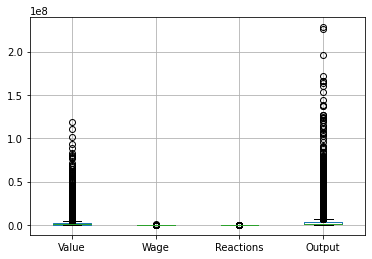

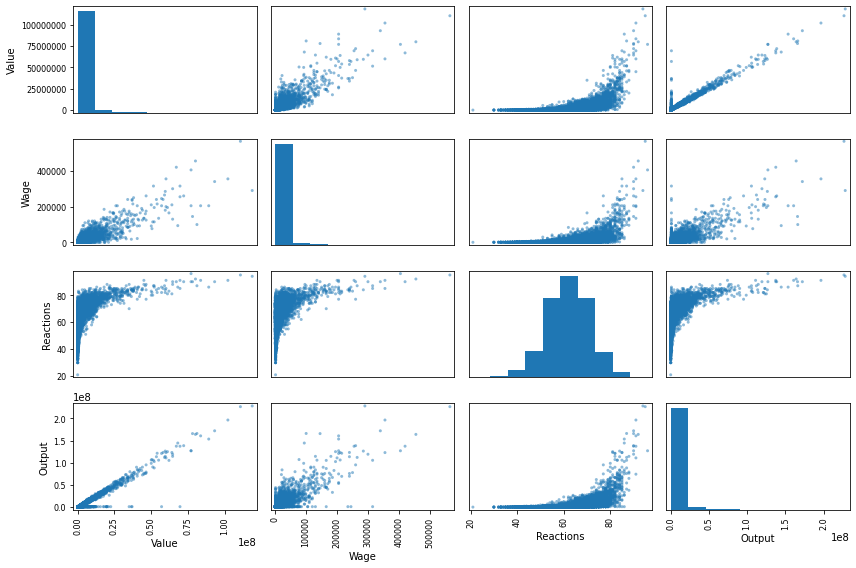

In [ ]:
from pandas.plotting import scatter_matrix

Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

<class 'numpy.ndarray'>


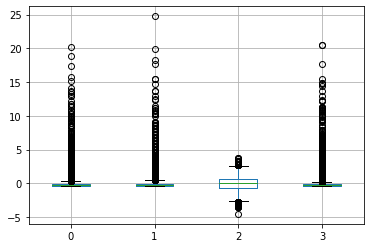

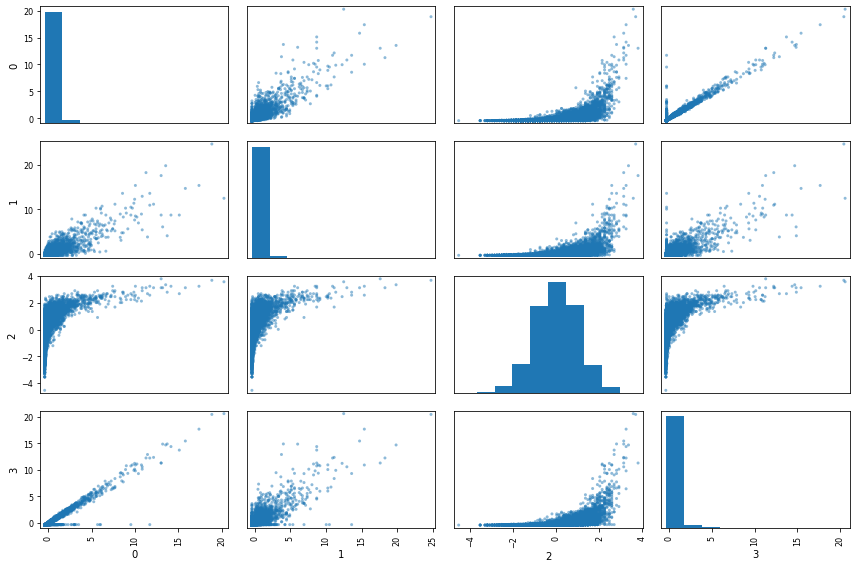

In [ ]:
# Se importa preprocesing para usar StandarScaler y MinMaxScaler

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# StandarScaler
scaler = StandardScaler().fit_transform(Xm)
print(type(scaler))
X_Standar_Scaler = pd.DataFrame(scaler)
# MinMaxScaler
min_max_scaler =preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(Xm)
X_train_minmax = pd.DataFrame(X_train_minmax)
type(X_train_minmax)

X_Standar_Scaler.boxplot()#grafica de caja
plt.show()
scatter_matrix(X_Standar_Scaler, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

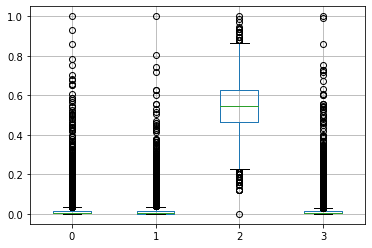

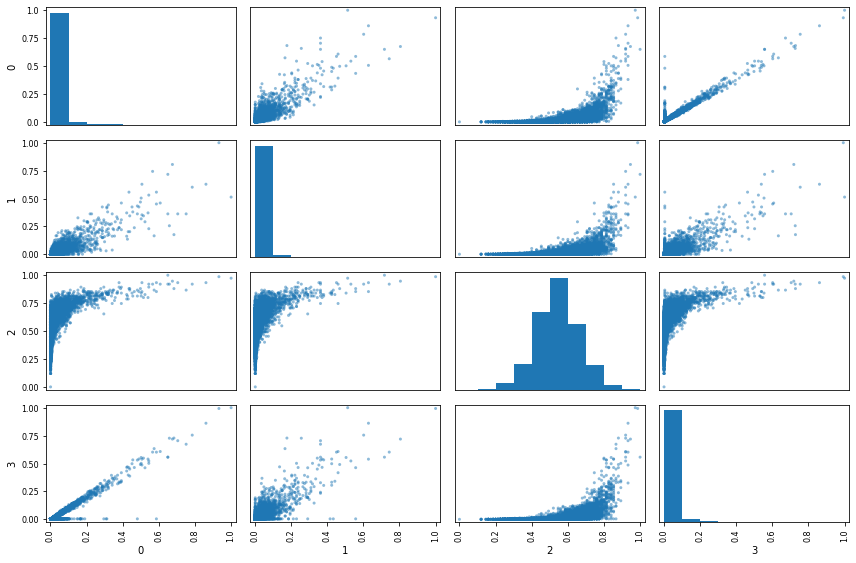

In [ ]:
X_train_minmax.boxplot()#grafica de caja
plt.show()
scatter_matrix(X_train_minmax, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

# Se define pipeline para entrenar un modelo de regresión

**Nota:** Se sugiere utilizar un preproceso de normalización tipo StandardScaler o MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.


A continuación se genera pipeline completo inlcuyendo preproceso custom, standardscaler y modelo de regresión lineal por mínimos cuadrados.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)), 
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Akinfenwa',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Shaqiri', 'Courtois',
                                                   'C. Ronaldo', 'Messi',
                                                   'Neymar'],
                                     'Club': ['Empoli', 'Fortuna Düsseldorf',
                                              'Arsenal', 'Valencia CF',
                                              'AS Monaco',
                                              'Wolverhampton Wanderers',
                                              'Borussia Dortmund',
                                              'Manchester City',
                                              'TSG 1899 Hoffenheim',
                                              'Liverpool', 

In [ ]:
ytest_e = metodo_full.predict(Xtest) #se evalua el desempeño en el conjunto de test


Se grafican salida original y las predicciones

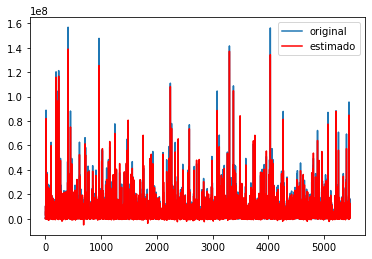

In [ ]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')

plt.legend()
plt.show()

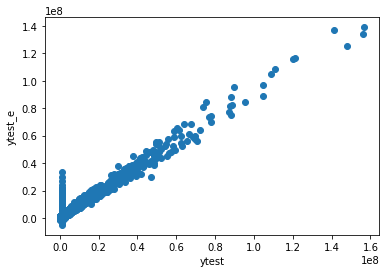

In [ ]:
plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)

 ## Solución 2
 se presentan algunos métodos que se espera que el valor objetivo sea una combinación lineal de las caracteristicas que se basa en el siguiente modelo:

$$y = f(x) = w_0 + w_1 x_1 + \dots + w_p x_p$$

- **LinearRegresor**: matemáticamente el problema a optimizar es:

$$ \min\limits_w  \left\|{Xw-y}\right\|_{2}^{2}$$

- **Lasso:** matemáticamente, es un modelo lineal que contiene un termino de regularización. La función objetivo a minimizar es:

$$\min\limits_w\frac{1}{2n_{muestras}}\left\|{Xw-y}\right\|_{2}^{2}+\alpha\left\|{w}\right\|_{1}$$

Donde $\left\|{w}\right\|_{1}$ es la norma $\mathscr{l}_1$ del vestor de los pesos.

- **Elastic-Net**: es un modelo de regresión lineal entrenado con ambas normas $\mathbb{l}_1$ y $\mathbb{l}_2$. La función objetivo a minimizar en este caso es:

$$\min\limits_w\frac{1}{2n_{muestras}}\left\|{Xw-y}\right\|_{2}^{2} + \alpha\rho\left\|{w}\right\|_{1} + \frac{\alpha(1-\rho)}{2}\left\|{w}\right\|_{2}^{2}$$

Es necesario ajustar los parametros $\alpha$ y $\rho$

- **Kernel ridge:** La función a optimizar en Kernel Ridge es:
\begin{equation}
\omega^* = \arg\min_\omega \|y-\Phi \omega\|^2_2 + \alpha\|\omega\|^2_2
\end{equation}

Cabe resaltar que el modelo es: 
$y = f(x) = w_0 + \Phi{w_1} x_1 + \dots + \Phi{w_p} x_p$, donde $\Phi$ es una función que puede ser no lineal.

- **SGDRegressor** para este debemos de optimizar e siguiente problema:

$$\min\limits_{w,\rho,\xi}\frac{1}{2}||\mathbf{w}||^2 - \rho + \frac{1}{\nu n}\sum_{i=1}^{n}\xi_i$$
Donde:
$$<\mathbf{w},\mathbf{x_i}>\geq \rho-\xi_{i}$$
Con $1\leq i \leq n$ y $\xi_i\geq 0$


- **BayesianRidge** este estima un modelo probabilistico del problema de regresión, este viene dado por#

$$p(\mathbf{w}|\lambda) = \nu (\mathbf{w}|0,\lambda^{-1} I_{p})$$

Donde $\alpha$ y $\lambda$ se conocen como parámetros de regularización y son elegidos mientras se este ajustando el modelos.


3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



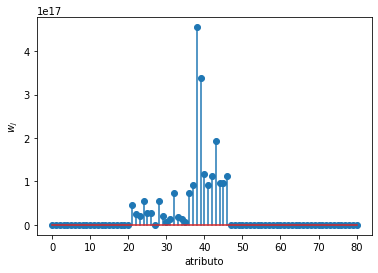

In [ ]:
#el pipeline contiene el método steps codificando los elementos del proceso. 
#En este caso el regresor esta en la posición 2 y en la 1 de la tupla arrojada
#Revisando la documentación de LinearRegression, el atributo coef_ contiene las cargas del modelo
plt.stem(abs(metodo_full.steps[2][1].coef_))
plt.xlabel('atributo')
plt.ylabel('$w_j$')
plt.show()

Se aprecia que las cargas del modelo que mayor peso tienen son las que están en el centro, estas son las que se maximizan, el resto presenta un comportamiento al rededor del cero.  

In [ ]:
np.argmax(abs(metodo_full.steps[2][1].coef_))
Xtrain.columns[38] #Máximo
np.argsort(abs(metodo_full.steps[2][1].coef_))#los atributos más importantes
Xtrain.columns[np.argsort(abs(metodo_full.steps[2][1].coef_))] 

Index(['Dribbling', 'Height', 'Interceptions', 'Jumping', 'Stamina',
       'Work Rate', 'Composure', 'Balance', 'Acceleration', 'ShortPassing',
       'LongShots', 'Strength', 'LongPassing', 'GKKicking', 'Jersey Number',
       'Vision', 'Preferred Foot', 'Agility', 'StandingTackle', 'Reactions',
       'Weak Foot', 'ShotPower', 'HeadingAccuracy', 'GKHandling', 'Aggression',
       'Nationality', 'Marking', 'Curve', 'Weight', 'GKReflexes',
       'Skill Moves', 'Penalties', 'Body Type', 'Real Face', 'FKAccuracy',
       'Joined', 'Position', 'GKDiving', 'BallControl', 'SprintSpeed',
       'International Reputation', 'Positioning', 'Potential', 'Club', 'Age',
       'Special', 'Volleys', 'Finishing', 'Crossing', 'Contract Valid Until',
       'GKPositioning', 'SlidingTackle', 'Overall', 'Wage', 'Value', 'RF',
       'RCM', 'CAM', 'CM', 'RAM', 'LCM', 'RS', 'LAM', 'ST', 'LF', 'CF', 'LS',
       'RW', 'LW', 'LM', 'RM', 'LWB', 'RWB', 'CB', 'RCB', 'RB', 'LB', 'RDM',
       'LCB', 'CDM', 'L

In [ ]:
#Dado que el preproceso no cambia, se sugiera generar el pipeline sin mypre_fifa para ahorrar tiempo
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps) #pipeline a utilizar en el gridsearch
#Recuerde realizar el fit del gridsearch sobre las matrices de entrada y vector de salida preprocesados
#Xtrain_pre ytrain_num


In [ ]:
# definir modelos de predicción
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error as msa 


steps = [
        #  [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
        #   ('reg', LinearRegression())],
         
        #  [('scaler',StandardScaler()),
        #  ('reg',Ridge())],

        #  [('scaler',StandardScaler()),
        #  ('reg',Lasso())],
         
        # ('scaler',StandardScaler()),
         # ('reg',ElasticNet())
         
           ('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
           ('reg',  KernelRidge(kernel = 'rbf')) #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
            #  {'reg__fit_intercept':[True, False]             
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Ridge
            #   'reg__fit_intercept':[True, False] 
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Lasso
            #   'reg__fit_intercept':[True, False] 
            #  },
            # {
            #  'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros ElasticNet
            #  'reg__l1_ratio':[0,0.25,0.5,0.75,1]
            # }
              {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
              'reg__alpha':[1e-3,1e-2,1e-1,1,10]
              }
              ]



pipeline = Pipeline(steps = steps)

scoring = {'absolute':'neg_mean_absolute_error','squares':'neg_mean_squared_error'}# diccionario metricas error https://scikit-learn.org/stable/modules/model_evaluation.html

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, cv=5, scoring=scoring, verbose=10, refit='absolute')# refit se escoje la metrica con la que desea optimizar 

grid_search.fit(Xtrain_pre[:5000], ytrain_num[:5000]) # Validación cruzada; indexamos porque sino se explota 

ypred = grid_search.predict(Xtest_pre) # Predicción mejores Hiper-parametros

list_hyper=grid_search.best_params_ #guardar mejores parametros
msev=msa(ytest_num,ypred) # guardar mean_absolute_error

print(list_hyper, msev)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'reg__alpha': 0.1, 'reg__gamma': 0.001} 851314.7287652022


In [ ]:
steps = [
          ('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
           ('reg', LinearRegression()),
         
        #  [('scaler',StandardScaler()),
        #  ('reg',Ridge())],

        #  [('scaler',StandardScaler()),
        #  ('reg',Lasso())],
         
         #('scaler',StandardScaler()),
         # ('reg',ElasticNet())
         
          # [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          # ('reg',  KernelRidge(kernel = 'rbf'))] #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
                           {'reg__fit_intercept':[True, False]             
              },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Ridge
            #   'reg__fit_intercept':[True, False] 
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Lasso
            #   'reg__fit_intercept':[True, False] 
            #  },
           #  {
            #  'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros ElasticNet
            #  'reg__l1_ratio':[0,0.25,0.5,0.75,1]
            # }
            #  {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
            #  'reg__alpha':[1e-3,1e-2,1e-1,1,10]
            #  }
              ]

pipeline = Pipeline(steps = steps)

scoring = {'absolute':'neg_mean_absolute_error','squares':'neg_mean_squared_error'}# diccionario metricas error https://scikit-learn.org/stable/modules/model_evaluation.html

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, cv=5, scoring=scoring, verbose=10, refit='absolute')# refit se escoje la metrica con la que desea optimizar 

grid_search.fit(Xtrain_pre, ytrain_num) # Validacion cruzada 

ypred = grid_search.predict(Xtest_pre) # Prediccion mejores Hiper parametros

list_hyper=grid_search.best_params_ #guardar mejores parametros
msev=msa(ytest_num,ypred) # guardar mean_absolute_error

print(list_hyper, msev)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'reg__fit_intercept': True} 902718.5107083598


In [ ]:
steps = [
        #  [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
        #   ('reg', LinearRegression())],
         
        #  [('scaler',StandardScaler()),
        #  ('reg',Ridge())],

          ('scaler',StandardScaler()),
          ('reg',Lasso()),
         
         #('scaler',StandardScaler()),
         # ('reg',ElasticNet())
         
          # [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          # ('reg',  KernelRidge(kernel = 'rbf'))] #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
                           {'reg__fit_intercept':[True, False]             
              },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Ridge
            #   'reg__fit_intercept':[True, False] 
            #  },
              {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Lasso
               'reg__fit_intercept':[True, False] 
              },
           #  {
            #  'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros ElasticNet
            #  'reg__l1_ratio':[0,0.25,0.5,0.75,1]
            # }
            #  {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
            #  'reg__alpha':[1e-3,1e-2,1e-1,1,10]
            #  }
              ]

pipeline = Pipeline(steps = steps)

scoring = {'absolute':'neg_mean_absolute_error','squares':'neg_mean_squared_error'}# diccionario metricas error https://scikit-learn.org/stable/modules/model_evaluation.html

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, cv=5, scoring=scoring, verbose=10, refit='absolute')# refit se escoje la metrica con la que desea optimizar 

grid_search.fit(Xtrain_pre, ytrain_num) # Validacion cruzada 

ypred = grid_search.predict(Xtest_pre) # Prediccion mejores Hiper parametros

list_hyper=grid_search.best_params_ #guardar mejores parametros
msev=msa(ytest_num,ypred) # guardar mean_absolute_error

print(list_hyper, msev)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'reg__alpha': 10, 'reg__fit_intercept': True} 900420.379338545


In [ ]:
steps = [
        #  [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
        #   ('reg', LinearRegression())],
         
        #  [('scaler',StandardScaler()),
        #  ('reg',Ridge())],

        #  [('scaler',StandardScaler()),
         # ('reg',Lasso())],
         
         ('scaler',StandardScaler()),
          ('reg',ElasticNet())
         
          # [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          # ('reg',  KernelRidge(kernel = 'rbf'))] #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
                           {'reg__fit_intercept':[True, False]             
              },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Ridge
            #   'reg__fit_intercept':[True, False] 
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Lasso
            #   'reg__fit_intercept':[True, False] 
            #  },
             {
              'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros ElasticNet
              'reg__l1_ratio':[0,0.25,0.5,0.75,1]
             }
            #  {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
            #  'reg__alpha':[1e-3,1e-2,1e-1,1,10]
            #  }
              ]

pipeline = Pipeline(steps = steps)

scoring = {'absolute':'neg_mean_absolute_error','squares':'neg_mean_squared_error'}# diccionario metricas error https://scikit-learn.org/stable/modules/model_evaluation.html

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, cv=5, scoring=scoring, verbose=10, refit='absolute')# refit se escoje la metrica con la que desea optimizar 

grid_search.fit(Xtrain_pre, ytrain_num) # Validacion cruzada 

ypred = grid_search.predict(Xtest_pre) # Prediccion mejores Hiper parametros

list_hyper=grid_search.best_params_ #guardar mejores parametros
msev=msa(ytest_num,ypred) # guardar mean_absolute_error

print(list_hyper, msev)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'reg__alpha': 0.01, 'reg__l1_ratio': 0} 870240.2295868514


Luego de probar todos los modelos se obtuvo la siguiente tabla 

### Resultados
| Modelo | MSEV 
| --- | --- | 
| Kernel Ridge | 919.385 
| Regresión Lineal | 936.324 
| Lasso | 937.605 
| Elastic Net | 906.985 

Y ase aprecia que el modelo que presenta el menor error es la regresión E-net, que mezcla ambas normas, esta minimiza los regresores que no aportan y maximiza los que son realmente importantes. 

# Ejemplo Validación cruzada anidada

Cuando se tienen pocos datos se realiza una validación cruzada 

In [ ]:
from sklearn.model_selection import KFold

Niter = 5 #numero particiones cross-validation(Folds)
kf = KFold(n_splits=Niter)

msev = [] #arreglo para guardar acierto/error
list_hyper = [] #lista  guardar mejores hyperparametros por iteracion

for train_index, test_index in kf.split(Xtrain_pre): # Validacion cruzada anidada
  print("TRAIN:", train_index, "TEST:", test_index)
  grid_search.fit(Xtrain_pre.iloc[train_index], ytrain_num[train_index]) # Validacion cruzada interna(si la validacion no es anidada se corre desde la linea 60 fuera del for)

  ypred = grid_search.predict(Xtrain_pre.iloc[test_index])

  list_hyper.append(grid_search.best_params_)#guardar mejores parametros
  msev.append(msa(ytrain_num[test_index],ypred))#guardar acierto

TRAIN: [ 2549  2550  2551 ... 12741 12742 12743] TEST: [   0    1    2 ... 2546 2547 2548]
Fitting 5 folds for each of 32 candidates, totalling 160 fits
TRAIN: [    0     1     2 ... 12741 12742 12743] TEST: [2549 2550 2551 ... 5095 5096 5097]
Fitting 5 folds for each of 32 candidates, totalling 160 fits
TRAIN: [    0     1     2 ... 12741 12742 12743] TEST: [5098 5099 5100 ... 7644 7645 7646]
Fitting 5 folds for each of 32 candidates, totalling 160 fits
TRAIN: [    0     1     2 ... 12741 12742 12743] TEST: [ 7647  7648  7649 ... 10193 10194 10195]
Fitting 5 folds for each of 32 candidates, totalling 160 fits
TRAIN: [    0     1     2 ... 10193 10194 10195] TEST: [10196 10197 10198 ... 12741 12742 12743]
Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
print(msev,'\n',list_hyper)

[896214.9337134416, 943521.4667815435, 964396.4634649932, 838146.4233630424, 867998.0588748567] 
 [{'reg__alpha': 0.01, 'reg__l1_ratio': 0}, {'reg__alpha': 0.01, 'reg__l1_ratio': 0}, {'reg__alpha': 0.1, 'reg__l1_ratio': 0.75}, {'reg__alpha': 0.01, 'reg__l1_ratio': 0}, {'reg__alpha': 0.01, 'reg__l1_ratio': 0}]


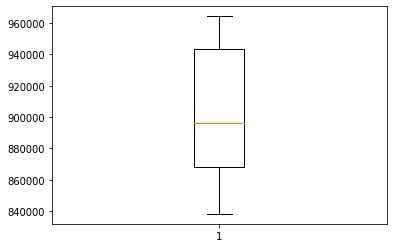

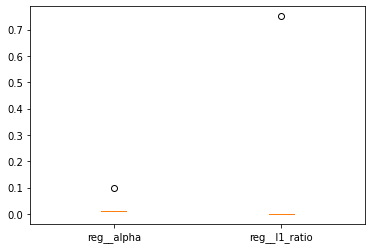

In [ ]:
plt.boxplot(msev)
plt.show()

data=np.zeros((len(list_hyper), len(list_hyper[0])))
i=0
for dic in list_hyper:
  result = dic.items()
  for j in range(len(list_hyper[0])):
    data[i,j]=list(result)[j][1]
  i+=1

plt.boxplot(data)
plt.xticks(ticks=np.arange(len(list_hyper[0]))+1,labels=list(list_hyper[0].keys()))
plt.show()